In [73]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
# import pandas.stats.moments as st
import statsmodels.api as sm # import statsmodels 
from pandas import ExcelWriter
import matplotlib.pyplot as pyplot
import scipy.stats as st
import os
import quandl as qd
from collections import defaultdict
import seaborn as sns
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

# Changing Directory
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\SPX Option Backtester\\crypto_testing\\Data')

In [179]:
# Importing data from Quandl

btc = qd.get("BITFINEX/BTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
eth = qd.get("BITFINEX/ETHUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
ltc = qd.get("BITFINEX/LTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
neo = qd.get("BITFINEX/NEOUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")


,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2017-09-07,39.800,22.300,30.5525,30.411,30.415,30.690,269772.012257
2017-09-08,31.637,22.320,25.9525,25.900,25.912,25.993,291852.004274
2017-09-09,26.270,22.180,23.3955,23.351,23.358,23.433,139533.241697
2017-09-10,25.400,19.529,24.0725,24.202,23.943,24.202,175813.285869
2017-09-11,24.500,21.509,21.9105,21.880,21.873,21.948,79686.038107


In [135]:
# List of Crypto Data
# BTC ETH XRP BCH LTC DASH NEM Monero IOTA ETC OMG NEO BCC LSK
# Data has Open, High, Low, Close, Volume, Marketcap

fast = 1
slow = 10

def crypto_ma_opt(crypto = 'BTC', fast = 1, slow = 10, show_values = False):
    
    df = pd.read_excel('cryptodata.xlsx', sheetname = crypto, index_col = 0).sort_index()
    
    df['fast'] = df[['Close']].rolling(fast).mean().shift(1)
    df['slow'] = df['Close'].rolling(slow).mean().shift(1)
    
    df['return'] = df['Close']/df['Close'].shift(1) - 1
    df['signal'] = df['fast'] >= df['slow']
    
    df['signal_return'] = df['signal']*df['return'].shift(-1)
    df['cumulative_return'] = ((df['return']+1).cumprod() - 1)
    df['signal_cumulative'] = ((df['signal_return']+1).cumprod() - 1)
    
    df = df.dropna()
    
    cumulative_return = df['cumulative_return'][-1]
    signal_cumulative = df['signal_cumulative'][-1]
    
    df_graph = df[['cumulative_return','signal_cumulative']]
    df_graph.columns = [crypto + ' Cumulative Return', 'Algo Cumulative Return']
    
    if show_values:
        print(str(round(cumulative_return,2)))
        print(str(round(signal_cumulative,2)))
        df_graph.plot(figsize = (20,10))
        pyplot.title(crypto + ' Cumulative Returns', fontsize = 30)
        pyplot.ylabel('Returns', fontsize = 20)
        pyplot.xlabel('Date', fontsize = 20)
        pyplot.tick_params(labelsize=16)
        pyplot.legend(prop={'size': 16})
    
    return signal_cumulative

In [165]:
#slow_range = np.arange(5,45,5)
#fast_range = np.arange(5,25,5)

#testdf = pd.DataFrame(columns = cols, index = rows)

#for i in range(len(slow_range)):
#    for j in range(len(fast_range)):
#        row = slow_range[i]
#        col = fast_range[j]
#        if i > j:
#            testdf.iloc[i,j] = row*col

def heat_map(df,crypto):
    """
    This creates our heatmap using our sharpe ratio dataframe
    """
    fig = pyplot.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values,cmap = pyplot.get_cmap('RdYlGn'), interpolation = 'nearest')
    ax.set_xlabel(df.columns.name, fontsize = 16)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns), fontsize = 16)
    ax.set_ylabel(df.index.name, fontsize = 16)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index), fontsize = 16)
    ax.set_title(crypto + " SMA Returns", fontsize = 20)
    pyplot.colorbar(axim)
    
def sma_opt(fast_upper, slow_upper, crypto, show_heat = True, show_returns = False, show_backtest = False):
    
    # This will create a list with 9 entries
    short_mavg_days = [days for days in np.arange(5, fast_upper, 5)]
    # This will create a list with 43 entries
    long_mavg_days = [days for days in np.arange(10, slow_upper, 5)]

    #: Create a dictionary to hold all the results of our algorithm run
    all_returns = defaultdict(dict)

    # Count the number of backtests run
    backtest_count = 0

    # This will loop and run backtests
    # Each backtest takes about 3 seconds
    for short_mavg_day in short_mavg_days:
        for long_mavg_day in long_mavg_days:
            # Only consider cases where the short is less than long.. but why this not working?
            if short_mavg_day < long_mavg_day:
                
                curr_return = crypto_ma_opt(crypto, short_mavg_day, long_mavg_day)
                
                # Keep track of how many backtests were run
                if show_backtest:
                    backtest_count += 1
                    print("Backtest " + str(backtest_count) + " completed...")
            
                #: Add the result to our dict
                all_returns[short_mavg_day][long_mavg_day] = curr_return

    if show_backtest:
        print(" ")
        print("All backtest simulations completed!")
        print(" ")

    all_returns = pd.DataFrame(all_returns)
    all_returns.index.name = "Long Moving Average Days"
    all_returns.columns.name = "Short Moving Average Days"
    
    if show_heat:
        heat_map(all_returns, crypto)
    
    short_opt = all_returns.max().idxmax()
    long_opt = all_returns.max(axis = 1).idxmax()
    ret_opt = max(all_returns.max())
    print("Optimal MA cross is: " + str(short_opt) + "-" + str(long_opt))
    print("With optimal return: " + str(round((ret_opt-1)*100,2)) + "%")
    
    if show_returns:
        crypto_ma_opt(crypto, short_opt, long_opt, show_values = True)
    
    return all_returns



Optimal MA cross is: 10-50
With optimal return: 12022.93%
36.55
121.23


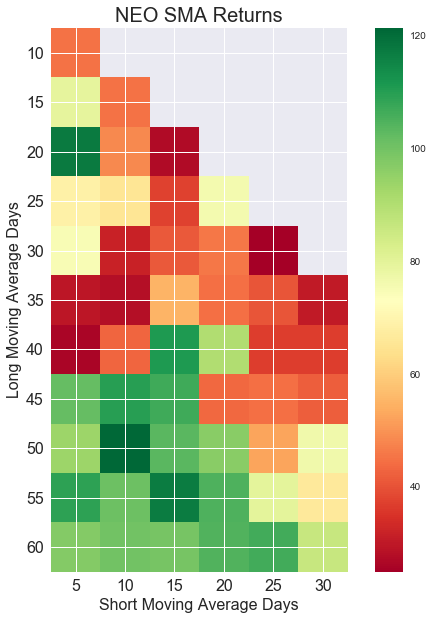

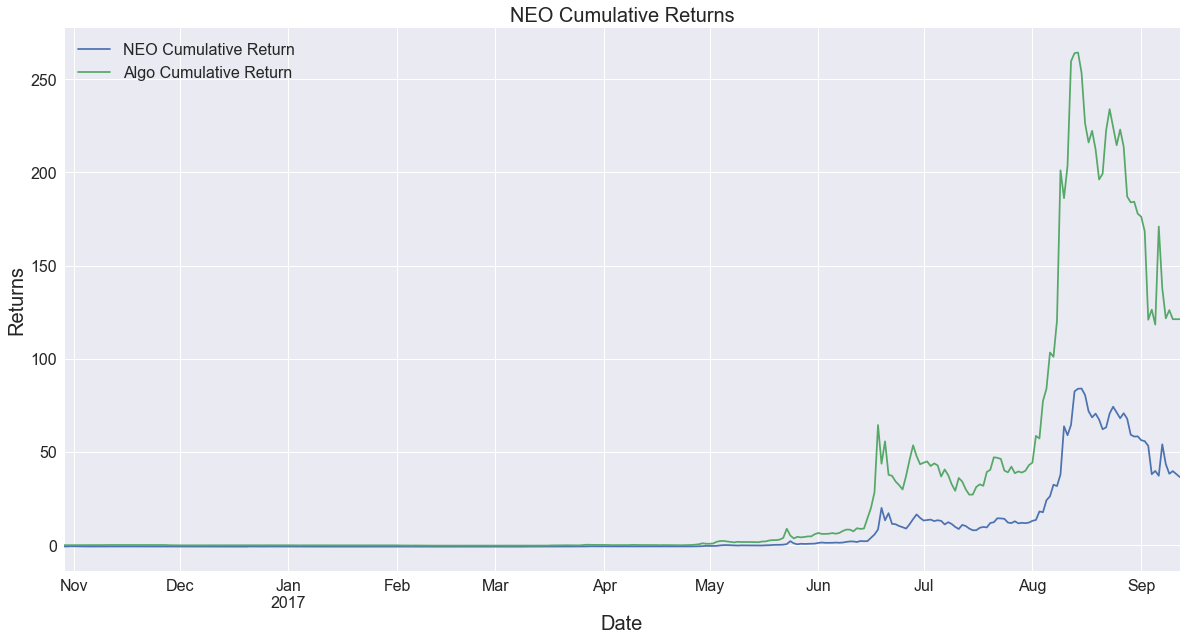

In [169]:
ret_df = sma_opt(35, 65, 'NEO', show_heat = True, show_returns = True)

In [170]:
# Crypto latest MAs
# BTC 10-20
# ETH 15-30
# LTC 25-40
# NEO 10-50

def crypto_ma_signal(crypto = 'BTC', fast = 1, slow = 10):
    
    df = pd.read_excel('cryptodata.xlsx', sheetname = crypto, index_col = 0).sort_index()
    
    df['fast'] = df[['Close']].rolling(fast).mean().shift(1)
    df['slow'] = df['Close'].rolling(slow).mean().shift(1)
    
    df['return'] = df['Close']/df['Close'].shift(1) - 1
    df['signal'] = df['fast'] >= df['slow']
    
    return df[['Close','fast','slow','signal']].tail(5)



In [171]:
crypto_ma_signal('BTC', 10, 20)

,Close,fast,slow,signal
Date,,,,
2017-09-23,3792.40,3704.084,4015.1735,False
2017-09-24,3682.84,3695.065,3975.6455,False
2017-09-25,3926.07,3747.854,3947.9720,False
2017-09-26,3892.35,3776.709,3925.4490,False
2017-09-27,4200.67,3803.440,3890.2105,False


In [172]:
crypto_ma_signal('ETH', 15, 30)

,Close,fast,slow,signal
Date,,,,
2017-09-23,286.17,272.554667,308.790000,False
2017-09-24,282.48,271.866000,307.475333,False
2017-09-25,292.33,271.071333,305.827333,False
2017-09-26,287.44,271.310000,304.442333,False
2017-09-27,306.47,270.837333,302.427333,False


In [173]:
crypto_ma_signal('LTC', 25, 40)

,Close,fast,slow,signal
Date,,,,
2017-09-23,49.27,62.5656,57.62150,True
2017-09-24,47.62,62.0096,57.70825,True
2017-09-25,51.58,61.3476,57.81600,True
2017-09-26,51.55,60.5684,58.00175,True
2017-09-27,56.28,59.1888,58.19275,True


In [180]:
crypto_ma_signal('NEO', 10, 50)

,Close,fast,slow,signal
Date,,,,
2017-09-23,20.18,19.216,29.1082,False
2017-09-24,19.79,19.228,29.3032,False
2017-09-25,26.02,19.638,29.4186,False
2017-09-26,26.38,20.366,29.6348,False
2017-09-27,31.79,20.928,29.7888,False


10.85
190.22


190.21775875380831

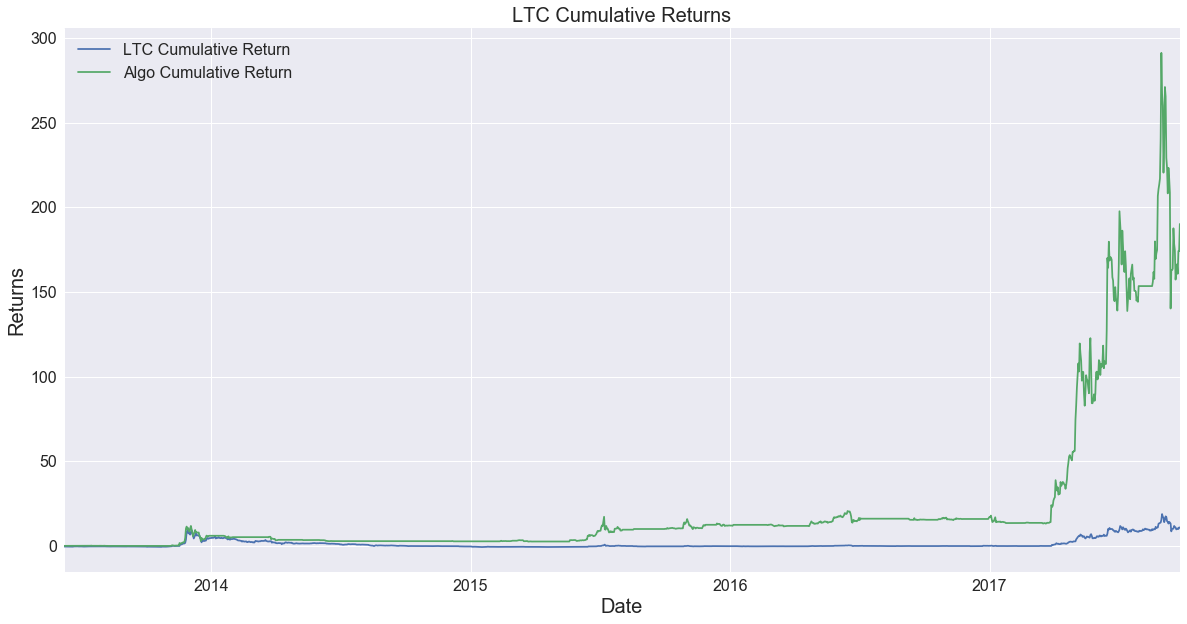

In [182]:
crypto_ma_opt(crypto = 'LTC', fast = 25, slow = 40, show_values = True)